---
**Project**: Submarine Route Constraints  
**Author**: Alejandra L. Cameselle  
**Date**: July 2025  
**Notebook**: 04 – Define Cable Exclusion Zones Based on Depth

### Description  
This notebook computes exclusion and caution zones around existing submarine cables using a raster-based approach. According to international guidelines (ICPC), minimum separation distances between submarine cables are defined as a function of water depth. Dynamic buffer zones are generated using raster distance thresholds and then vectorized and cleaned for use in risk scoring.

### Inputs  
- `telecom_cables_dummy_clipped.gpkg`: Clipped submarine cable routes  
- `bathymetry_clipped.tif`: Bathymetric raster clipped to AOI  
- `AOI.gpkg`: Area of interest polygon for final clipping

### Processing  
- Compute raster distance from cable geometries  
- Apply 2× and 3× water depth thresholds to generate binary masks  
- Vectorize and clean resulting masks  
- Subtract 2WD zone from 3WD to avoid overlap  
- Explode multipolygons and clip to AOI

### Outputs  
- `04_cable_exclusion_zone_2WD.gpkg`: Hard exclusion area (score = 100)  
- `04_cable_exclusion_zone_3WD.gpkg`: Caution area (score = 80, adjusted)  
- `04_raster_buffer_results.png`: Map visualization of zones

### Assumptions  
- Depth raster contains negative values (e.g., -1200 m)  
- Raster and vector layers share the same CRS  
- Buffers are computed and classified from raster thresholds, not vector buffers

### Dependencies  
- rasterio, numpy, geopandas, shapely, matplotlib  
---

In [1]:
# Load libraries
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.enums import Resampling
from rasterio.features import shapes
from scipy.ndimage import distance_transform_edt
from shapely.geometry import shape
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from rasterio.plot import show

In [2]:
# Define file paths
orig_dem = "../inputs/bathymetry_clipped.tif"
cables_path = "../processed_data/constraints/telecom_cables_dummy_clipped.gpkg"
upsampled_dem = "../processed_data/04_bathymetry_10m.tif"

In [3]:
# Upsample DEM from 100m to 10m resolution
with rasterio.open(orig_dem) as src:
    scale = src.res[0] / 10.0  # e.g., 100/10 = 10
    new_height = int(src.height * scale)
    new_width = int(src.width * scale)
    profile = src.profile.copy()
    profile.update({
        "height": new_height,
        "width": new_width,
        "transform": src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )
    })
    with rasterio.open(upsampled_dem, "w", **profile) as dst:
        data = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=Resampling.bilinear
        )
        dst.write(data)
    print(f"DEM upsampled to 10m resolution: {upsampled_dem}")

DEM upsampled to 10m resolution: ../processed_data/04_bathymetry_10m.tif


In [4]:
# Compute distance transform and variable thresholds
with rasterio.open(upsampled_dem) as dem:
    depth = dem.read(1)
    transform = dem.transform
    crs = dem.crs
    # Rasterize cables to DEM grid
    cable_shapes = [(geom, 1) for geom in gpd.read_file(cables_path).geometry]
    cable_mask = rasterio.features.rasterize(
        cable_shapes,
        out_shape=depth.shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype="uint8"
    )
    # Distance in meters
    pixel_size = dem.res[0]
    dist2cable = distance_transform_edt(1 - cable_mask) * pixel_size
    # Variable thresholds: 2× and 3× depth (only underwater)
    thresh2x = np.where(depth < 0, -depth * 2, 0)
    thresh3x = np.where(depth < 0, -depth * 3, 0)
    # Binary masks for exclusion and caution zones
    mask2x = dist2cable <= thresh2x
    mask3x = dist2cable <= thresh3x
    print("Masks computed: exclusion (2x), caution (3x)")

Masks computed: exclusion (2x), caution (3x)


In [5]:
# Vectorize binary masks into GeoDataFrames
def mask_to_gdf(mask, transform, crs):
    geoms = []
    for geom, val in shapes(mask.astype("uint8"), transform=transform):
        if val == 1:
            geoms.append(shape(geom))
    return gpd.GeoDataFrame(geometry=geoms, crs=crs)

buf2 = mask_to_gdf(mask2x, transform, crs)
buf3 = mask_to_gdf(mask3x, transform, crs)
print(f"Vectorized {len(buf2)} exclusion polygons and {len(buf3)} caution polygons")

Vectorized 1 exclusion polygons and 1 caution polygons


In [6]:
# Dissolve geometries
buf2_dissolved = buf2.dissolve()
buf3_dissolved = buf3.dissolve()

In [7]:
# Clip the exclusion and caution zones to the area of interest (AOI)

# Load AOI
aoi = gpd.read_file('../inputs/aoi.gpkg')

# Clip dissolved zones to AOI polygon
buf2_clipped = gpd.overlay(buf2_dissolved, aoi, how='intersection')
buf3_clipped = gpd.overlay(buf3_dissolved, aoi, how='intersection')

# Save clipped zones to GeoPackage files
buf2_clipped.to_file('../processed_data/04_cable_exclusion_zone_2WD.gpkg', driver='GPKG')
buf3_clipped.to_file('../processed_data/04_cable_exclusion_zone_3WD.gpkg', driver='GPKG')

# Overwrite original variables with clipped versions
buffer_zone_2x = buf2_clipped
buffer_zone_3x = buf3_clipped

print("Clipping completed. Buffer zones saved.")

Clipping completed. Buffer zones saved.


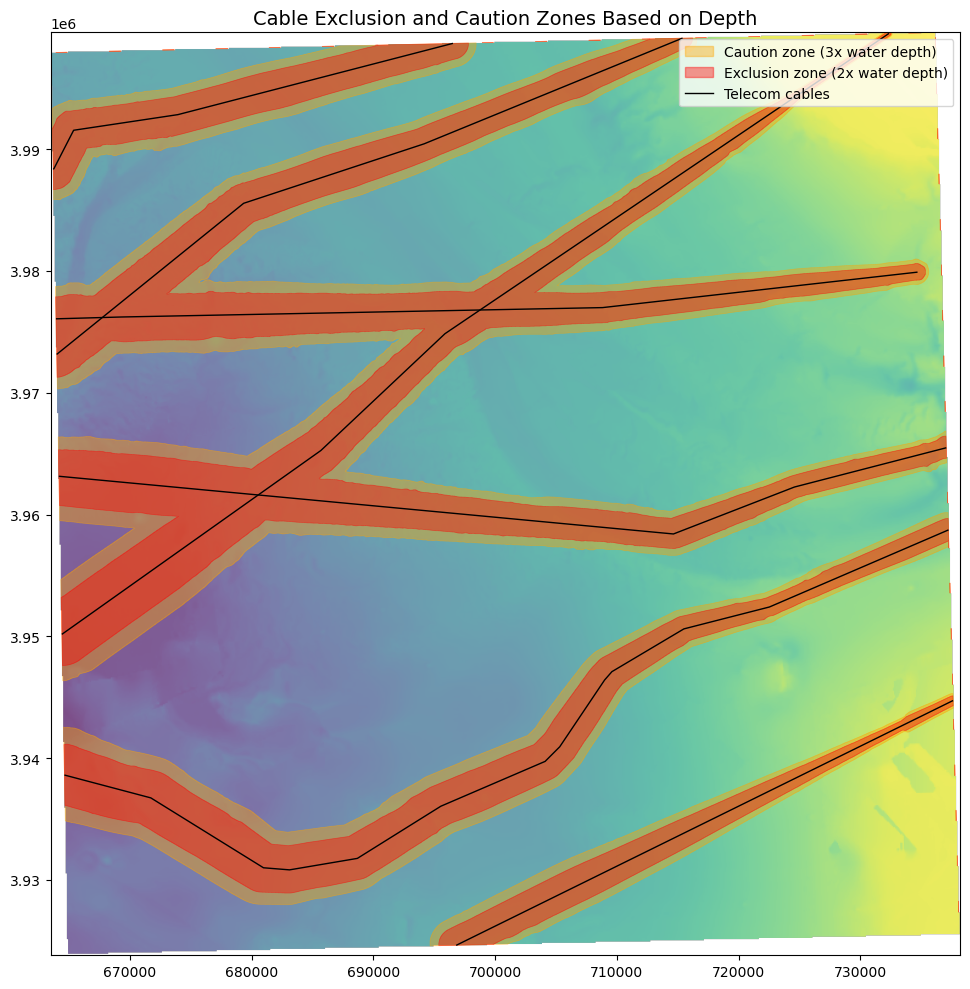

Visualization saved to: ../outputs/plots/04_raster_buffer_results.png


In [8]:
# Visualization of results
plot_dir = "../outputs/plots"
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, "04_raster_buffer_results.png")

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the bathymetry raster
with rasterio.open('../inputs/bathymetry_clipped.tif') as src:
    show(src, ax=ax, cmap='viridis', alpha=0.7)

# Plot the caution zone (3x water depth)
buffer_zone_3x.plot(ax=ax, color='orange', alpha=0.4, edgecolor='orange', linewidth=0.5)

# Plot the exclusion zone (2x water depth)
buffer_zone_2x.plot(ax=ax, color='red', alpha=0.4, edgecolor='red', linewidth=0.5)

# Plot cable routes
cables = gpd.read_file(cables_path)
cables.plot(ax=ax, color='black', linewidth=1)

# Create custom legend elements
patch_caution = mpatches.Patch(color='orange', alpha=0.4, label='Caution zone (3x water depth)')
patch_exclusion = mpatches.Patch(color='red', alpha=0.4, label='Exclusion zone (2x water depth)')
line_cables = Line2D([0], [0], color='black', linewidth=1, label='Telecom cables')

# Configure legend and axes
ax.legend(handles=[patch_caution, patch_exclusion, line_cables], loc='upper right')
ax.set_title('Cable Exclusion and Caution Zones Based on Depth', fontsize=14)

plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"Visualization saved to: {plot_path}")